In [1]:
### Loading the IMDB dataset in Keras

from keras.datasets import imdb

#The argument num_words=10000 means you’ll only keep the top 10k most frequently occurring words in the training data.
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

#looking at the training set
print(train_data[0])
print(train_labels[0]) #a 0-label stands for negative and 1-label stands for positive

#because you’re restricting yourself to the top 10k most frequent words, no word index will exceed 10k
print(max([max(sequence) for sequence in train_data]))

#decoding a review
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
#the next line decodes the first review. Note that the indices are offset by 3
#because 0, 1, and 2 are reserved indices for “padding,” “start of sequence,” and “unknown.”
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
print(decoded_review)

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1
9999
? this film was just brilliant casting location scene

**Preparação dos dados**

Não é possível usar listas de inteiros em uma rede neural. É necessário converter as listas em tensores. Existem duas maneiras de se fazer isso:
- Preencher suas listas para que todas tenham o mesmo comprimento, transformá-las em um tensor de inteiros com forma (amostras, índices_de_palavras) e, em seguida, usar como primeira camada em sua rede uma camada capaz de lidar com esses tensores de inteiros (a camada `Embedding`, que abordaremos em detalhes mais tarde).
- Codificar suas listas usando *one-hot encoding* para transformá-las em vetores de 0s e 1s. Isso significaria, por exemplo, transformar a sequência [3, 5] em um vetor de 10.000 dimensões, que seria todo de 0s, exceto nos índices 3 e 5, que seriam 1s. Então, você poderia usar como a primeira camada em sua rede uma camada `Dense`, capaz de lidar com vetor de dados de ponto flutuante.

Vamos seguir com a última solução para vetorizar os dados.

In [2]:
import numpy as np


def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1.
  return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

print(x_train[0])

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

[0. 1. 1. ... 0. 0. 0.]


**Construindo a rede**

Os dados de entrada são vetores, e os rótulos são escalares (1s e 0s): esta é a configuração mais simples que você encontrará. Um tipo de rede que se sai bem nesse problema é uma pilha simples de camadas totalmente conectadas (`Dense`) com ativações `relu`: `Dense(16, activation='relu')`.

O argumento passado para cada camada Dense (16) é o número de unidades ocultas da camada. Uma *unidade oculta* é uma dimensão no espaço de representação da camada. Lembre-se de que cada camada `Dense` com ativação `relu` implementa a seguinte sequência de operações tensoriais:

`output = relu(dot(W, input) + b)`

Ter 16 unidades ocultas significa que a matriz de pesos `W` terá forma `(dimensão_de_entrada, 16)`: o produto escalar (`dot`) com `W` projetará os dados de entrada em um espaço de representação de 16 dimensões (e depois o vetor de viés `b` será adicionado e se aplicará a operação `relu`). Você pode entender intuitivamente a dimensionalidade do seu espaço de representação como "quanta liberdade você está permitindo que a rede tenha ao aprender representações internas". Ter mais unidades ocultas (um espaço de representação de maior dimensão) permite que sua rede aprenda representações mais complexas, mas torna a rede computacionalmente mais cara e pode levar a aprender padrões indesejados (padrões que melhorarão o desempenho nos dados de treinamento, mas não nos dados de teste).

Existem duas decisões-chave de arquitetura a serem tomadas sobre essa pilha de camadas `Dense`:
- Quantas camadas usar
- Quantas unidades ocultas escolher para cada camada

Na próxima aula, você aprenderá princípios formais para orientar na tomada dessas decisões. Por enquanto, terá que confiar em mim com a seguinte escolha de arquitetura:
- Duas camadas intermediárias com 16 unidades ocultas cada
- Uma terceira camada que produzirá a previsão escalar sobre o sentimento da resenha atual

As camadas intermediárias usarão `relu' como sua função de ativação, e a camada final usará uma função de ativação sigmóide para produzir uma probabilidade (uma pontuação entre 0 e 1, indicando a probabilidade de a amostra ter o alvo "1": a probabilidade da resenha ser positiva).

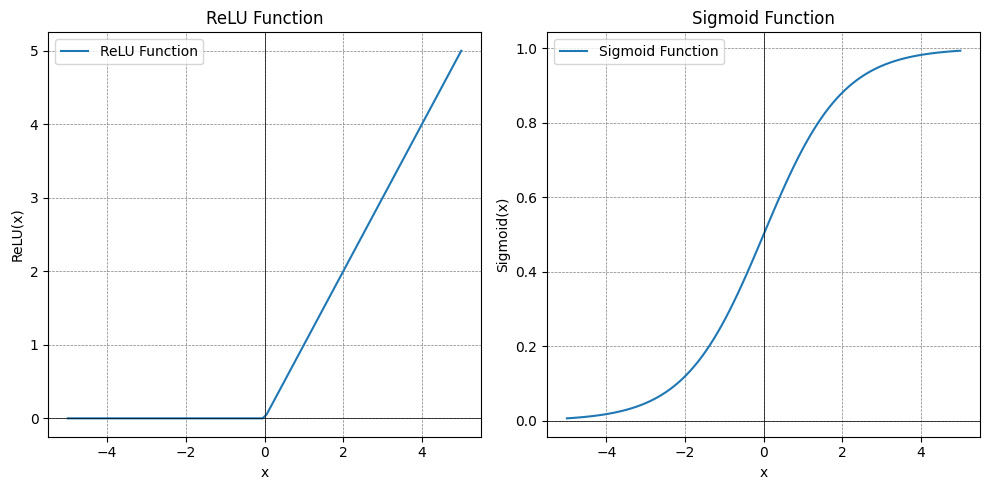

In [3]:
### printing the relu and the sigmoid functions

import matplotlib.pyplot as plt
import numpy as np

def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.linspace(-5, 5, 100)
y_relu = relu(x)
y_sigmoid = sigmoid(x)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(x, y_relu, label='ReLU Function')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.title('ReLU Function')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.subplot(1, 2, 2)
plt.plot(x, y_sigmoid, label='Sigmoid Function')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel('x')
plt.ylabel('Sigmoid(x)')
plt.title('Sigmoid Function')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In [4]:
from keras import models
from keras import layers
from keras.layers import Input

model = models.Sequential()
model.add(Input(shape=(10000,)))  # Define the input shape with the Input layer
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


**Digressão: o que são funções de ativação e por que são necessárias?**

Sem uma função de ativação como `relu` (também chamada de *não-linearidade*), a camada `Dense` consistiria em duas operações lineares - um produto escalar e uma adição:

`output = dot(W, input) + b`

Assim, a camada só poderia aprender *transformações lineares* (transformações afins) dos dados de entrada: o espaço de hipóteses da camada seria o conjunto de todas as possíveis transformações lineares dos dados de entrada em um espaço de 16 dimensões. Tal espaço de hipóteses é muito restrito e não se beneficiaria de várias camadas de representações, pois uma pilha profunda de camadas lineares ainda implementaria uma operação linear: adicionar mais camadas não estenderia o espaço de hipóteses.

Para obter acesso a um espaço de hipóteses muito mais rico que se beneficiaria de representações profundas, é necessário uma não-linearidade ou função de ativação. `relu` é a função de ativação mais popular em aprendizado profundo, mas existem muitas outras opções, que têm nomes igualmente estranhos: `prelu`, `elu`, e assim por diante.

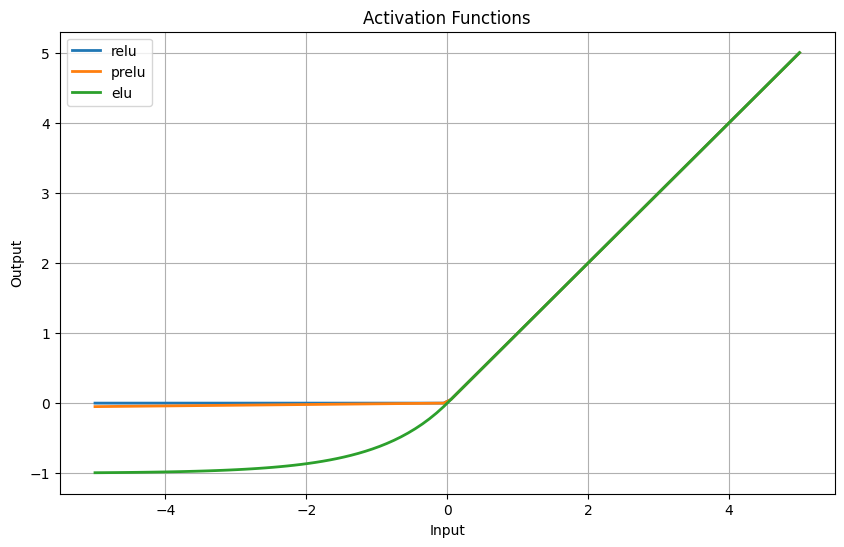

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define the activation functions
def relu(x):
    return np.maximum(0, x)

def prelu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def elu(x, alpha=1.0):
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

# Generate x values
x_values = np.linspace(-5, 5, 100)

# Compute y values for each activation function
relu_values = relu(x_values)
prelu_values = prelu(x_values)
elu_values = elu(x_values)

# Plot the activation functions
plt.figure(figsize=(10, 6))
plt.plot(x_values, relu_values, label='relu', linewidth=2)
plt.plot(x_values, prelu_values, label='prelu', linewidth=2)
plt.plot(x_values, elu_values, label='elu', linewidth=2)

# Add labels and legend
plt.title('Activation Functions')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

Por fim, você precisa escolher uma função de perda e um otimizador. Como você está lidando com um problema de classificação binária e a saída da sua rede é uma probabilidade (você encerra sua rede com uma camada de unidade única com ativação sigmóide), é melhor usar a perda `binary_crossentropy`. Não é a única escolha viável: você poderia usar, por exemplo, `mean_squared_error`. Mas a entropia cruzada geralmente é a melhor escolha quando lidamos com modelos que geram probabilidades. A *entropia cruzada* é uma quantidade da área da Teoria da Informação que mede a distância entre distribuições de probabilidade ou, neste caso, entre a distribuição verdadeira e suas previsões.

In [6]:
### Compiling the model

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

Alternativamente, é possível customizar o otimizador e a função perda

In [7]:
### Configuring the optimizer

from keras import optimizers
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
loss='binary_crossentropy',
metrics=['accuracy'])

In [8]:
### Using custom losses and metrics

from keras import losses
from keras import metrics
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
loss=losses.binary_crossentropy,
metrics=[metrics.binary_accuracy])

**Validando a abordagem**

Para monitorar durante o treinamento a precisão do modelo em dados que nunca viu antes, você criará um conjunto de validação reservando 10k amostras do conjunto original de dados de treinamento.

In [9]:
### Setting aside a validation set

x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

Agora você treinará o modelo por 20 épocas (20 iterações sobre todas as amostras nos tensores x_train e y_train), em lotes de 512 amostras. Ao mesmo tempo, você monitorará a perda e a precisão nas 10.000 amostras que reservou, fazendo isso ao passar os dados de validação como o argumento validation_data.

In [10]:
### Treinando o modelo

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - acc: 0.6892 - loss: 0.6096 - val_acc: 0.8614 - val_loss: 0.4189
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8874 - loss: 0.3641 - val_acc: 0.8834 - val_loss: 0.3251
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9169 - loss: 0.2625 - val_acc: 0.8905 - val_loss: 0.2878
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9355 - loss: 0.2080 - val_acc: 0.8875 - val_loss: 0.2806
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9490 - loss: 0.1666 - val_acc: 0.8871 - val_loss: 0.2750
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9585 - loss: 0.1398 - val_acc: 0.8856 - val_loss: 0.2813
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9660 - loss: 0.1215 - val_acc: 0.8829 - val_loss: 0.2988
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9702 - loss: 0.1071 - val_acc: 0.8780 - val_loss: 0.3135
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9777 - loss:

Observe que a chamada `model.fit()` retorna um objeto da classe `History`. Este objeto possui um membro `history`, que é um dicionário contendo dados sobre tudo que aconteceu durante o treinamento. Vamos examiná-lo:

In [11]:
history_dict = history.history
history_dict.keys()

dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])

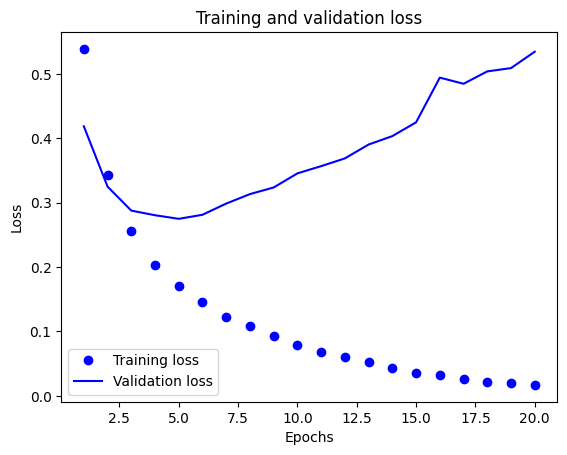

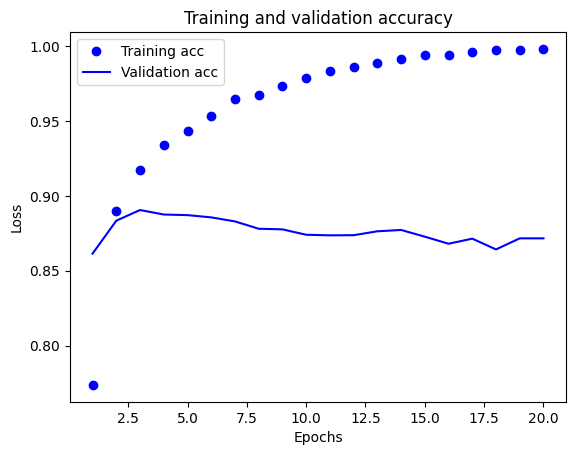

In [12]:
### Plotting the training and validation loss

import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history.history['acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Plotting the training and validation accuracy
plt.clf()
acc_values = history_dict['acc']
val_acc = history.history['val_acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Como se pode ver, a perda de treinamento diminui a cada época, e a precisão de treinamento aumenta a cada época. Isso é o que se esperaria ao executar a otimização por descida de gradiente - a quantidade que se está tentando minimizar deve ser menor a cada iteração. Mas esse não é o caso para a perda de validação e precisão: elas parecem atingir o pico na quarta época. Este é um exemplo do que avisamos anteriormente: um modelo que se sai melhor nos dados de treinamento não é necessariamente um modelo que se sairá melhor em dados que nunca viu antes. Em termos precisos, o que está ocorrendo é um **overfitting**: após a segunda época, está se otimizando demais para os dados de treinamento e acaba-se aprendendo representações específicas para esses dados de treinamento que não generalizam para dados fora do conjunto de treinamento.

Neste caso, para evitar o *overfitting*, poderíamos parar o treinamento após três épocas. Em geral, é possível usar uma variedade de técnicas para mitigar o overfitting, as quais abordaremos na próxima aula.

Vamos treinar uma nova rede do zero por quatro épocas e, em seguida, avaliá-la nos dados de teste.

In [13]:
### Retraining a model from scratch

model = models.Sequential()
model.add(Input(shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
print(results)

Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7517 - loss: 0.5465
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8997 - loss: 0.3073
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9145 - loss: 0.2424
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9285 - loss: 0.2078
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 823us/step - accuracy: 0.8881 - loss: 0.2795
[0.2790199816226959, 0.8890799880027771]


Esta abordagem bastante ingênua alcança uma precisão de 88%. Com abordagens melhores, é possível conseguir se aproximar de 95%.

**Usando uma rede treinada para gerar previsões a partir de novos dados**

In [14]:
model.predict(x_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 812us/step


array([[0.24127653],
       [0.9994796 ],
       [0.7048433 ],
       ...,
       [0.11788404],
       [0.10454644],
       [0.50949275]], dtype=float32)

Como você pode ver, a rede está confiante para algumas amostras (0.99 ou mais, ou 0.01 ou menos), mas menos confiante para outras (0.6, 0.4).

**REGULARIZAÇÃO**


**1. Reduzindo o tamanho da rede**

A maneira mais simples de evitar o *overfitting* é reduzir o tamanho do modelo: o número de parâmetros aprendíveis no modelo (que é determinado pelo número de camadas e o número de unidades por camada). Na aprendizagem profunda, o número de parâmetros aprendíveis em um modelo é frequentemente chamado de **capacidade** do modelo. Intuitivamente, um modelo com mais parâmetros tem mais **capacidade de memorização** e, portanto, pode aprender facilmente um mapeamento perfeito (tipo um dicionário) entre amostras de treinamento e seus alvos - um mapeamento sem nenhum poder de generalização. Por exemplo, um modelo com 500k parâmetros binários poderia facilmente aprender a classe de cada dígito no conjunto de treinamento MNIST: precisaríamos apenas de 10 parâmetros binários para cada um dos 50k dígitos. Mas um modelo assim seria inútil para classificar novas amostras de dígitos. Lembre-se sempre disso: modelos de aprendizagem profunda tendem a ser bons em se ajustar aos dados de treinamento, mas o verdadeiro desafio é a generalização, não o ajuste.

Por outro lado, se a rede tiver recursos limitados de memorização, não será capaz de aprender esse mapeamento tão facilmente; assim, para minimizar sua perda, terá que recorrer a aprender representações comprimidas que tenham poder preditivo em relação aos alvos - precisamente o tipo de representações que nos interessa. Ao mesmo tempo, tenha em mente que você deve usar modelos que tenham parâmetros suficientes para que não ocorra subajuste: seu modelo não deve ficar carente de recursos de memorização. Há um compromisso a ser encontrado entre **capacidade excessiva** e **capacidade insuficiente**.

Infelizmente, não há uma fórmula mágica para determinar o número certo de camadas ou o tamanho ideal para cada camada. Deve-se avaliar uma variedade de arquiteturas diferentes (no seu conjunto de validação, e não no conjunto de teste, é claro) para encontrar o tamanho do modelo adequado para seus dados. O fluxo de trabalho geral para encontrar um tamanho de modelo apropriado é começar com um número relativamente pequeno de camadas e parâmetros, e aumentar o tamanho das camadas ou adicionar novas camadas até que você perceba retornos decrescentes em relação à perda de validação.

Vamos tentar fazer isso na rede de classificação de análises de filmes. Primeiramente, vamos tornar a rede menor.

**Exercício 1**
1. Diminua o tamanho de unidades ocultas das camadas `Dense' para 4 (em vez de 16) e tire conclusões sobre o fenômeno do *overfitting*;
2. Aumente o tamanho de unidades ocultas das camadas `Dense' para 512 (em vez de 16) e tire conclusões sobre o fenômeno do *overfitting*.

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5472 - loss: 0.9248 - val_accuracy: 0.6277 - val_loss: 0.6190
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7015 - loss: 0.5427 - val_accuracy: 0.8139 - val_loss: 0.4511
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8505 - loss: 0.3701 - val_accuracy: 0.8565 - val_loss: 0.3941
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9081 - loss: 0.2838 - val_accuracy: 0.8772 - val_loss: 0.3809
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9223 - loss: 0.2296 - val_accuracy: 0.8862 - val_loss: 0.3992
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9383 - loss: 0.2005 - val_accuracy: 0.8885 - val_loss: 0.4213
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9470 - loss: 0.1611 - val_accuracy: 0.8779 - val_loss: 0.5030
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9547 - loss: 0.1539 - val_accuracy: 0.8868 - val_loss

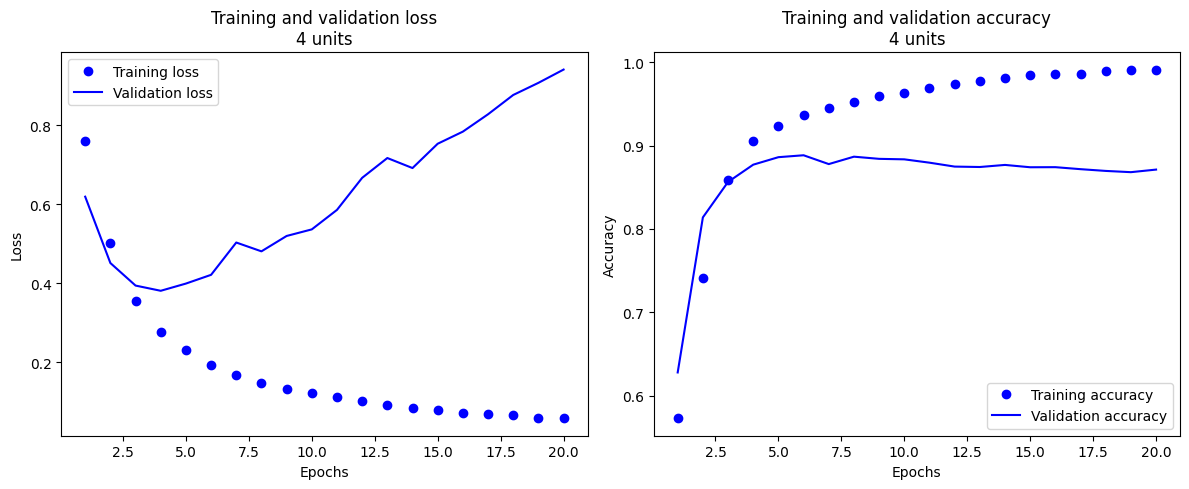

In [15]:
from tensorflow.keras import models, layers
import numpy as np

class FlexibleModel:
    def __init__(self, input_shape, num_hidden_layers=3, units_per_layer=64, optimizer='rmsprop', loss='mse', metrics=['mae']):
        self.input_shape = input_shape
        self.num_hidden_layers = num_hidden_layers
        self.units_per_layer = units_per_layer
        self.optimizer = optimizer
        self.loss = loss
        self.metrics = metrics

    def build_model(self):
        model = models.Sequential()
        model.add(Input(shape=(self.input_shape,)))
        model.add(layers.Dense(self.units_per_layer, activation='relu'))
        for _ in range(self.num_hidden_layers - 1):
            model.add(layers.Dense(self.units_per_layer, activation='relu'))
        model.add(layers.Dense(1))
        model.compile(optimizer=self.optimizer, loss=self.loss, metrics=self.metrics)
        return model
    

def plot_history(history, title_suffix):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = range(1, len(loss_values) + 1)

    plt.figure(figsize=(12,5))

    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot = left
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title(f'Training and validation loss\n{title_suffix}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    acc_values = history_dict['accuracy']
    
    val_acc_values = history_dict['val_accuracy'] if 'val_accuracy' in history_dict else history_dict['val_acc']

    plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
    plt.title(f'Training and validation accuracy\n{title_suffix}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    
model_creator = FlexibleModel(10000, 1, 4, loss='binary_crossentropy', metrics=['accuracy'])
model = model_creator.build_model()
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))
results = model.evaluate(x_test, y_test)
plot_history(history, '4 units')

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.4975 - loss: 7.1341 - val_accuracy: 0.5056 - val_loss: 7.8548
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5269 - loss: 6.9025 - val_accuracy: 0.7100 - val_loss: 0.5478
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8402 - loss: 0.4278 - val_accuracy: 0.8731 - val_loss: 0.4135
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9269 - loss: 0.2464 - val_accuracy: 0.8293 - val_loss: 0.9021
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9484 - loss: 0.1996 - val_accuracy: 0.8859 - val_loss: 0.4407
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9795 - loss: 0.1277 - val_accuracy: 0.8856 - val_loss: 0.5189
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9892 - loss: 0.0806 - val_accuracy: 0.8851 - val_loss: 0.5679
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9728 - loss: 0.1340 - val_accuracy: 0.8859 - v

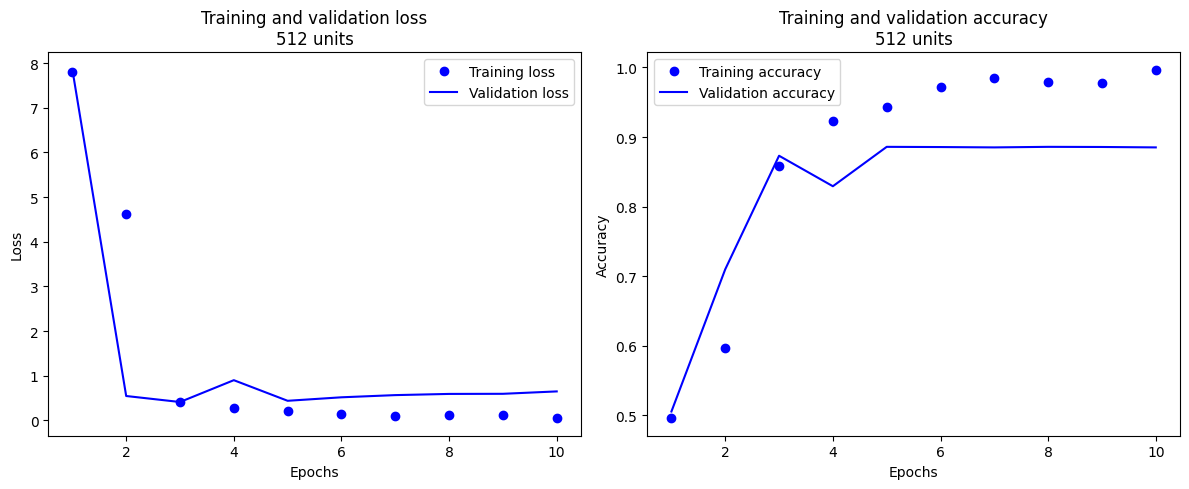

In [21]:
model_creator = FlexibleModel(10000, 1, 512, loss='binary_crossentropy', metrics=['accuracy'])
model = model_creator.build_model()
history = model.fit(partial_x_train, partial_y_train, epochs=10, batch_size=512, validation_data=(x_val, y_val))
model.evaluate(x_test, y_test)
plot_history(history, '512 units')


O primeiro gráfico (4 unidades) mostra um exemplo clássico de overfitting, pois a perda de treinamento continua a diminuir 
ao longo do tempo, o que é um bom sinal de que o modelo está aprendendo com os dados de treinamento.
Porém, a perda de validação, após um certo ponto, começa a aumentar. Isso significa que, embora o modelo esteja se 
tornando cada vez melhor em prever os dados de treinamento, ele está perdendo a capacidade de generalizar 
bem para os dados não vistos.



Para o segundo gráfico (512 unidades), parece que temos um caso de bom ajuste, pois a perda de treinamento cai rapidamente e,
 em seguida, estabiliza, o que é típico para um modelo durante o treinamento. 
 E a perda de validação parece ser bastante baixa e estável, o que indica que o modelo está generalizando 
 bem para os dados de validação.

**2. Adicionando regularização de pesos**

Você deve estar familiarizado com o princípio da **navalha de Occam**: dadas duas explicações para algo, a explicação mais provável de estar correta é a mais simples, aquela que faz menos suposições. Essa ideia também se aplica aos modelos aprendidos por redes neurais: dados alguns dados de treinamento e uma arquitetura de rede, vários conjuntos de valores de peso (múltiplos *modelos*) poderiam explicar os dados. Modelos mais simples têm menos probabilidade de sofrer *overfitting* do que os complexos.

Um **modelo simples**, neste contexto, é um modelo em que a distribuição dos valores dos parâmetros tem menos entropia (ou um modelo com menos parâmetros, como vimos na seção anterior). Assim, uma maneira comum de mitigar o *overfitting* é impor restrições à complexidade de uma rede, forçando seus pesos a terem apenas valores pequenos, o que torna a distribuição dos valores dos pesos mais **regular**. Isso é chamado de **regularização de pesos** e é feito adicionando à função de perda da rede um custo associado a ter pesos grandes. Esse custo vem em duas formas:
- **Regularização L1** — O custo adicionado é proporcional ao valor absoluto dos coeficientes de peso (a **norma L1** dos pesos).
- **Regularização L2** — O custo adicionado é proporcional ao quadrado do valor dos coeficientes de peso (a **norma L2** dos pesos). A regularização L2 também é chamada de **decaimento de pesos** no contexto de redes neurais.

No Keras, a regularização de peso é adicionada passando-se instâncias de regularizadores de peso para as camadas como argumentos. Vamos adicionar a regularização de peso L2 à rede de classificação de resenhas de filmes.

`l2(0.001)` significa que cada coeficiente na matriz de peso da camada adicionará `0,001 * valor_do_coeficiente_de_peso` ao total de perda da rede. Observe que, como essa penalidade é adicionada apenas durante o treinamento, a perda para esta rede será muito maior durante o treinamento do que durante o teste.

**Exercício 2**
1. Treine o modelo e gere os gráficos usuais. Comente o impacto da regularização L2 sobre o modelo gerado.
2. Use o código `regularizers.l1(0.001)` pare efetuar uma regularização L1 (em vez da L2). Treine o modelo e gere os gráficos usuais. Comente o impacto da regularização L1 sobre o modelo gerado.
3. Use o código `regularizers.l1_l2(l1=0.001, l2=0.001)` pare efetuar uma regularização mista. Treine o modelo e gere os gráficos usuais. Comente o impacto da regularização mista sobre o modelo gerado.

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 894us/step - accuracy: 0.8636 - loss: 0.4316


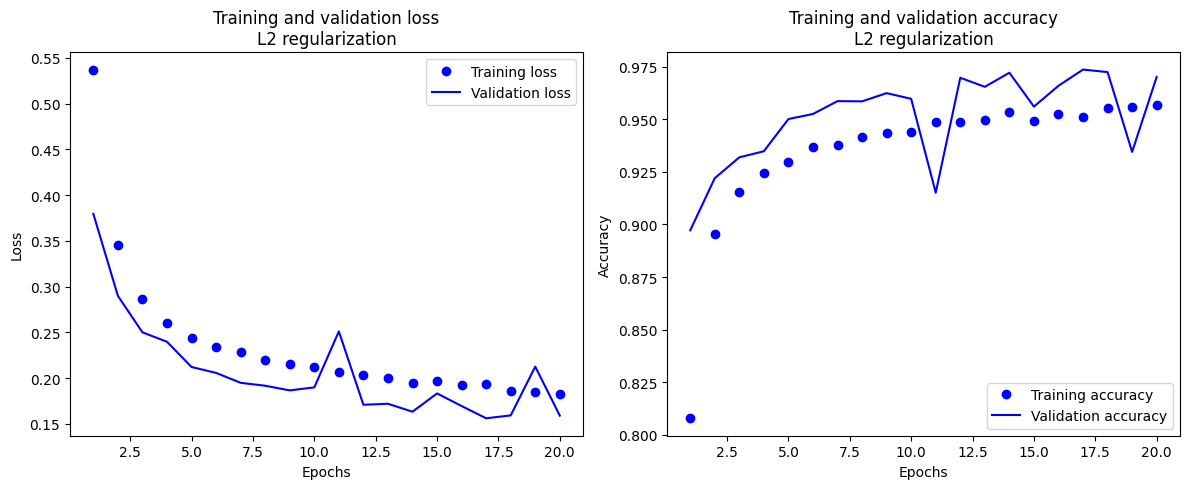

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 966us/step - accuracy: 0.8667 - loss: 0.5043


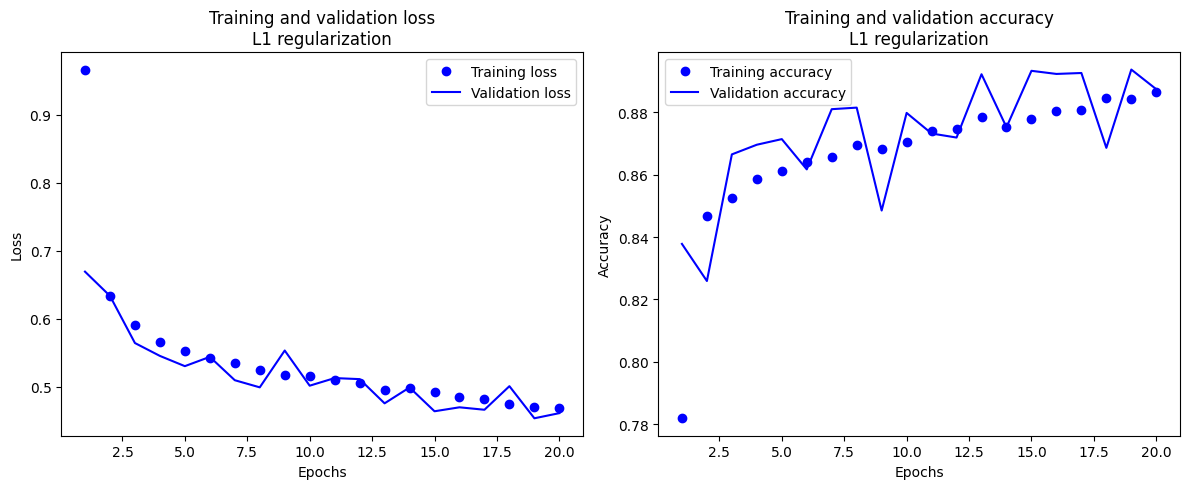

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 935us/step - accuracy: 0.8655 - loss: 0.5138


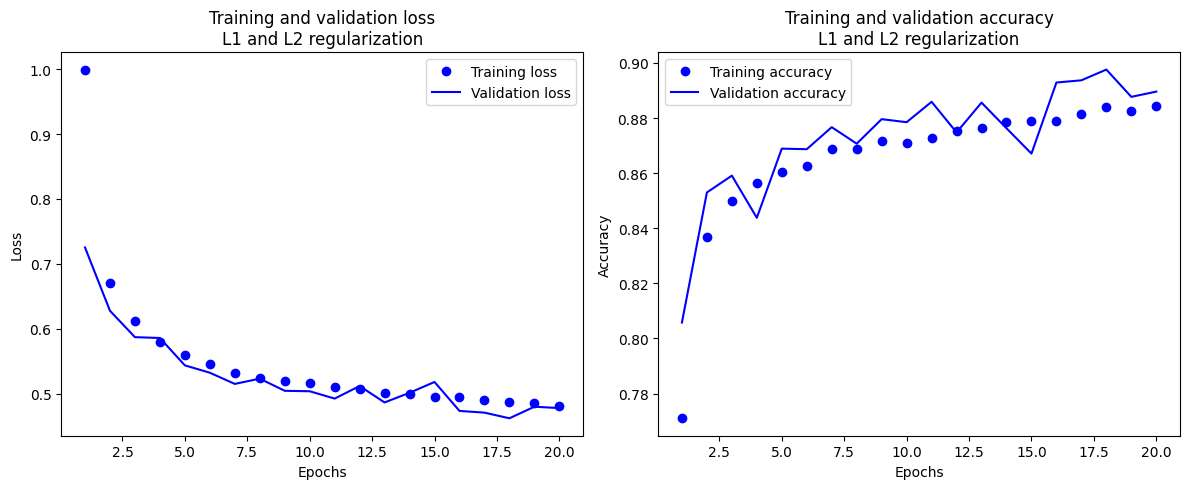

In [35]:
from keras import regularizers
model = models.Sequential()
model.add(Input(shape=(10000,)))
model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val), verbose=0)
model.evaluate(x_test, y_test)
plot_history(history, 'L2 regularization')


model = models.Sequential()
model.add(Input(shape=(10000,)))
model.add(layers.Dense(16, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
model.add(layers.Dense(16, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val), verbose=0)
model.evaluate(x_test, y_test)
plot_history(history, 'L1 regularization')


model = models.Sequential()
model.add(Input(shape=(10000,)))
model.add(layers.Dense(16, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), activation='relu'))
model.add(layers.Dense(16, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val), verbose=0)
model.evaluate(x_test, y_test)
plot_history(history, 'L1 and L2 regularization')

#### Regularização L2:
- O grafico da regularização L2 mostra que a perda de treinamento diminui de forma suave e consistente, o que sugere que a complexidade do modelo está sendo penalizada adequadamente, levando a menos overfitting. A perda de validação segue de perto a perda de treinamento, embora haja algumas flutuações, o que pode indicar que o modelo ainda experimenta variação com diferentes dados.

#### Regularização L1:
- Com relação à regularização L1, a perda de treinamento mostra um declínio mais errático em comparação com a L2, o que pode ser devido à natureza da regularização L1 que promove a escassez nos pesos do modelo, possivelmente levando a uma seleção de recursos benéfica, mas também potencialmente descartando algumas informações úteis. O gráfico de acurácia mostra mais volatilidade na precisão de validação em comparação com a L2, o que pode significar que o modelo é menos estável em diferentes conjuntos de dados. A tendência geral na precisão é ascendente, mas a inconsistência pode sugerir que o modelo poderia se beneficiar de ajuste de hiperparâmetros ou de uma abordagem diferente para a regularização.

#### Regularização L1 e L2:
- A perda de treinamento para o modelo com ambas as regularizações L1 e L2 combinadas diminui suavemente, de forma semelhante ao gráfico da L2. O efeito combinado da regularização L1 e L2 pode ajudar tanto a penalizar pesos grandes (efeito L2) quanto a criar escassez (efeito L1), oferecendo potencialmente um efeito de regularização equilibrado. O gráfico de acurácia para a regularização combinada mostra um alto nível de acurácia que melhora consistentemente à medida que as épocas aumentam. Há uma diferença notável entre a acurácia de treinamento e validação, no entanto, o que poderia sugerir que ainda há algum overfitting presente, ou que o modelo ainda está aprendendo com os dados de treino.

**3. Adicionando *dropout***

*Dropout* é uma das técnicas de regularização mais eficazes e comumente usadas para redes neurais, desenvolvida por Geoff Hinton e seus alunos na Universidade de Toronto. O *Dropout*, aplicado a uma camada, consiste em **desativar** aleatoriamente (configurar para zero) um número de características de saída da camada durante o treinamento. Digamos que uma determinada camada normalmente retornaria um vetor `[0.2, 0.5, 1.3, 0.8, 1.1]` para uma determinada amostra de entrada durante o treinamento. Após a aplicação do *Dropout*, este vetor terá algumas entradas zero distribuídas aleatoriamente, por exemplo, `[0, 0.5, 1.3, 0, 1.1]`. A **taxa de dropout** é a fração das características que são zeradas; geralmente é definida entre `0.2` e `0.5`. No momento do teste, nenhuma unidade é desativada; em vez disso, os valores de saída da camada são reduzidos por um fator igual à taxa de dropout, para equilibrar o fato de que mais unidades estão ativas do que no momento do treinamento.

Essa técnica pode parecer estranha e arbitrária. Por que isso ajudaria a reduzir o *overfitting*? Hinton diz que foi inspirado, entre outras coisas, por um mecanismo de prevenção de fraudes usado por bancos. Em suas próprias palavras, "Fui ao meu banco. Os caixas continuavam mudando e eu perguntei a um deles por quê. Ele disse que não sabia, mas que eram movidos com frequência. Eu imaginei que isso deveria ser porque seria necessário cooperação entre os funcionários para fraudar com sucesso o banco. Isso me fez perceber que remover aleatoriamente um subconjunto diferente de neurônios a cada exemplo impediria conspirações e, assim, reduziria o *overfitting*." A ideia central é que introduzir ruído nos valores de saída de uma camada pode quebrar padrões acidentais que não são significativos (o que Hinton chama de **conspirações**), os quais a rede começaria a memorizar se nenhum ruído estivesse presente.

No Keras, você pode introduzir o *Dropout* em uma rede por meio da camada *Dropout*, que é aplicada à saída da camada imediatamente antes dela:

`model.add(layers.Dropout(0.5))`

Aqui, `0.5` é a taxa de dropout, representando a fração de unidades de saída da camada que serão zeradas durante o treinamento. Essa taxa pode ser ajustada conforme necessário.

**Exercício 3**
1. Adicione duas camadas de *Dropout* ao modelo (imediatamente após a cada camada oculta do tipo `Dense`) com taxa de dropout `0.5`. Treine o modelo e gere os gráficos usuais. Comente o impacto da técnica sobre o modelo gerado.
2. Altere a taxa de dropout para `0.2` e discorra sobre os resultados.

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 976us/step - accuracy: 0.8665 - loss: 0.6456


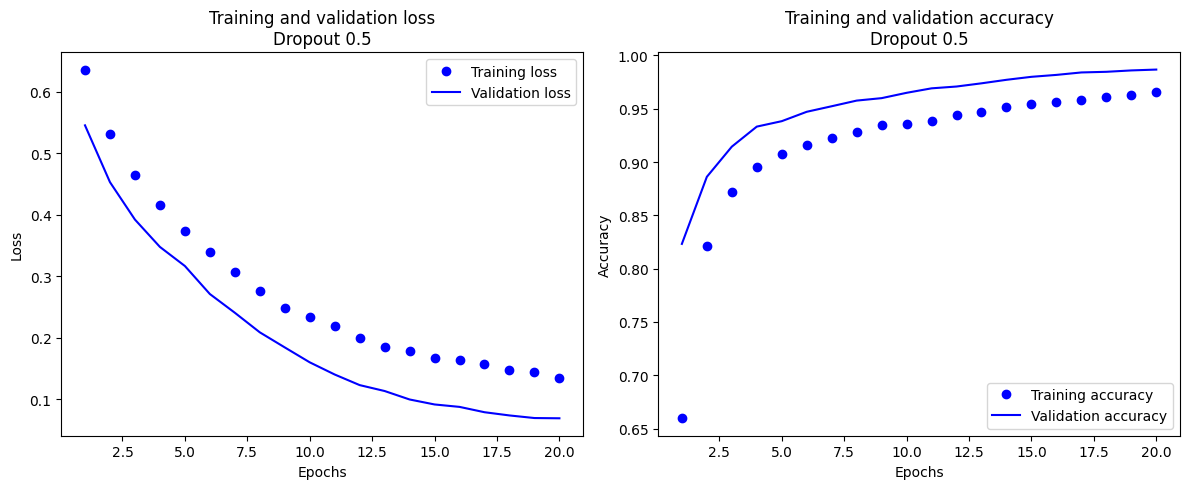

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 889us/step - accuracy: 0.8680 - loss: 0.7590


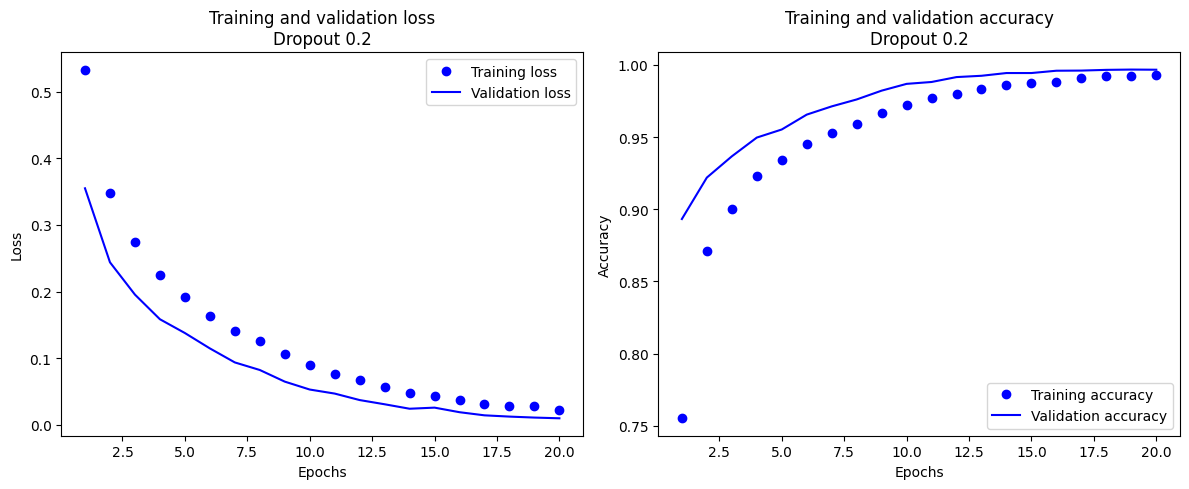

In [37]:
model = models.Sequential()
model.add(Input(shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val), verbose=0)
model.evaluate(x_test, y_test)
plot_history(history, 'Dropout 0.5')


model = models.Sequential()
model.add(Input(shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val), verbose=0)
model.evaluate(x_test, y_test)
plot_history(history, 'Dropout 0.2')

#### Impacto do Dropout 0.5:
- Quando aplicamos uma taxa de dropout de 0,5, o que significa zerar aleatoriamente 50% das saídas da camada anterior durante o treinamento, podemos observar a partir do gráfico que a perda de treinamento diminui significativamente. No entanto, há uma diferença perceptível entre a perda de treinamento e validação, indicando que o modelo está com um pouco de dificuldade de generalização, o que é esperado com uma taxa de dropout tão alta.

#### Impacto do Dropout 0.2:
- Reduzir a taxa de dropout para 0,2 parece ter um impacto benéfico na capacidade do modelo de generalizar, como evidenciado pela maior proximidade entre a perda de treinamento e validação. Uma taxa de dropout mais baixa significa que menos conexões são zeradas, o que pode ser mais apropriado para esse caso.